In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from brush import BrushPara
import numpy as np
from lmfit import Parameters, printfuncs
from refnx.analysis import Transform, CurveFitter
from refnx.dataset import ReflectDataset
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
# load the dataset
Q, R, dR, dQ = np.loadtxt('D2O45.txt', unpack=True)
data = tuple((Q.tolist(), R.tolist(), dR.tolist(), dQ.tolist()))
#NB d = ReflectDataset('example.txt') work if reduction done in refnx
d = ReflectDataset(data)

In [7]:
t = Transform('logY').transform

In [8]:
# Transform the data to log R
d.y, d.y_err = t(d.x, d.y, d.y_err)

In [9]:
#Initialise BushGauss Class
a = BrushPara(0.93, 2, n_slices=50, dq=8.85, transform=t)

In [10]:
#List parameter names
a.parameter_names()

['scale',
 'bkg',
 'SLD_super',
 'SLD_sub',
 'thickness_SiO2',
 'SLD_SiO2',
 'roughness_SiO2',
 'roughness_backing',
 'phi_init',
 'thickness_tail',
 'roughness_tail2int',
 'thickness_1',
 'phi_1',
 'roughness_1',
 'thickness_2',
 'phi_2',
 'roughness_2']

In [11]:
#Set up values parameters object and fill with appropriate values
P = Parameters()

vals = [0.97, 3.84e-7, 2.07, 6.23, 19.2, 3.1, 3, 5, 0.127, 50, 4,
            3.85, 0.99, 4.5, 224.135, 0.6591, 1]
lbs = [0.95, 1e-7, 2.06, 5.8, 5, 3, 2.9, 2, 0.006, 25,3,
            2, 0.1, 2, 1, 0.1, 1]
ubs = [1.1, 1e-6, 2.08, 6.36, 25, 3.47, 3.6, 8, 0.5, 250,50,
            100, 1.0, 5, 300, 0.8, 10]
varies = np.array([True] * 17, bool)
varies[[0, 2, 4, 5, 6]] = False

for name, val, vary, lb, ub in zip(a.parameter_names(), vals, varies, lbs, ubs):
    P.add(name, val, vary, lb, ub)

In [12]:
#Generate slab parameters and check that appropriate number generated
slab_pars = a.to_slab(P)
assert(slab_pars[0] * 4 + 8 == np.size(slab_pars))

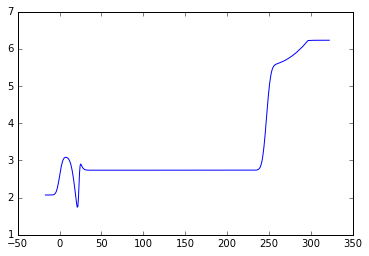

In [13]:
#Generate and plot SLD profile of initial parameters
z1, rho = a.sld_profile(P)
plt.plot(z1,rho)

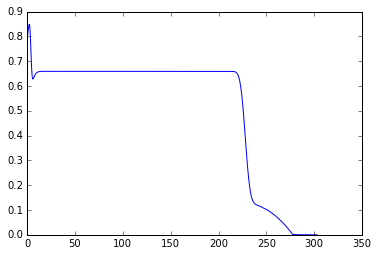

In [14]:
#Generate and plot volume fraction profile of initial parameters
z2, phi = a.vol_fraction(P)
plt.plot(z2,phi)

In [15]:
#Calculate and print area of intitial profile
area = a.vfp_area(P)
print(area)

155.05534785


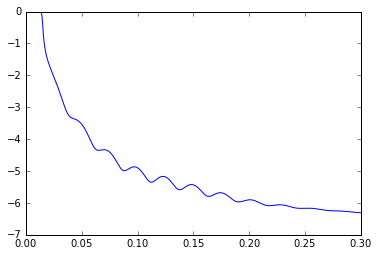

In [16]:
#Calculate and plot simulated reflectivity
q = np.linspace(0.01, 0.3, 1000)
ref = a.model(q, P)
plt.plot(q, ref)
# plt.xscale('log')

In [17]:
# Set up curve-fitting object with model, data and parameters
b = CurveFitter(a, d, P)

In [18]:
#Fit data
c = b.fit('differential_evolution',tol=0.001)

In [19]:
#Pritn Fit Report
print(printfuncs.fit_report(c))

[[Fit Statistics]]
    # function evals   = 180454
    # data points      = 104
    # variables        = 12
    chi-square         = nan
    reduced chi-square = nan
    Akaike info crit   = nan
    Bayesian info crit = nan
[[Variables]]
    scale:                0.97 (fixed)
    bkg:                  2.6820e-07 (init= 3.84e-07)
    SLD_super:            2.07 (fixed)
    SLD_sub:              6.32165000 (init= 6.23)
    thickness_SiO2:       19.2 (fixed)
    SLD_SiO2:             3.1 (fixed)
    roughness_SiO2:       3 (fixed)
    roughness_backing:    7.29514594 (init= 5)
    phi_init:             0.32281184 (init= 0.127)
    thickness_tail:       50.2420841 (init= 50)
    roughness_tail2int:   3.10105480 (init= 4)
    thickness_1:          9.27998999 (init= 3.85)
    phi_1:                0.94729665 (init= 0.99)
    roughness_1:          2.05530257 (init= 4.5)
    thickness_2:          109.000973 (init= 224.135)
    phi_2:                0.52066231 (init= 0.6591)
    roughness_2:    

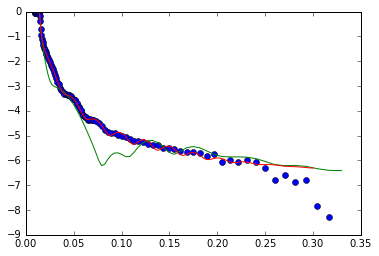

In [20]:
#Plot fit and original data
fit_ref = a.model(d.x,c.params)
plt.plot(d.x,d.y,'o',d.x,fit_ref,'-',q,ref)

In [21]:
#Check parameters
c.params

Parameters([('scale',
             <Parameter 'scale', value=0.97 (fixed), bounds=[0.95:1.1]>),
            ('bkg',
             <Parameter 'bkg', 2.6820321520239206e-07, bounds=[1e-07:1e-06]>),
            ('SLD_super',
             <Parameter 'SLD_super', value=2.07 (fixed), bounds=[2.06:2.08]>),
            ('SLD_sub',
             <Parameter 'SLD_sub', 6.3216499998447784, bounds=[5.8:6.36]>),
            ('thickness_SiO2',
             <Parameter 'thickness_SiO2', value=19.2 (fixed), bounds=[5:25]>),
            ('SLD_SiO2',
             <Parameter 'SLD_SiO2', value=3.1 (fixed), bounds=[3:3.47]>),
            ('roughness_SiO2',
             <Parameter 'roughness_SiO2', value=3 (fixed), bounds=[2.9:3.6]>),
            ('roughness_backing',
             <Parameter 'roughness_backing', 7.2951459431801746, bounds=[2:8]>),
            ('phi_init',
             <Parameter 'phi_init', 0.32281184610052438, bounds=[0.006:0.5]>),
            ('thickness_tail',
             <Parameter 'thickn

In [22]:
#Check integrated area
a.vfp_area(c.params)

76.06984305463132

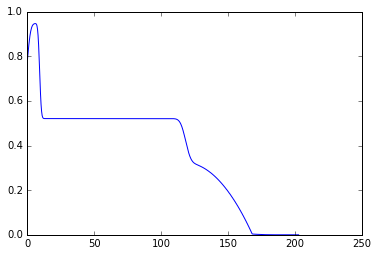

In [23]:
#Plot volume fraction profile
z, rho = a.vol_fraction(c.params)
plt.plot(z,rho)